## Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

## Set seed

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
set_seed(42)

## Load data

In [6]:
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')

print(df.head())
print(df.describe())
print(df.dtypes)

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

## Pre-process data

#### Change to categorical variables to binary/ordinal values

In [7]:
# Convert binary categorical variables to numeric
binary_features = ['housing', 'loan', 'subscribed']
for col in binary_features:
    df[col] = df[col].map({'no': 0, 'yes': 1})

# Convert poutcome to ordinal values
poutcome_mapping = {'failure': 0, 'nonexistent': 1, 'success': 2}
df['poutcome_encoded'] = df['poutcome'].map(poutcome_mapping)

# Convert contact type to binary
df['contact'] = df['contact'].map({'telephone': 0, 'cellular': 1})

# Bin pdays and previous
df['pdays_bins'] = df['pdays'].apply(lambda x: 'Never Contacted' if x == 999 else ('1-5' if x <= 5 else '6+'))
df['previous_bins'] = pd.cut(df['previous'], bins=[-1, 0, 1, float('inf')], labels=['Never', '1', '2+'])

# Drop unnecessary columns
df = df.drop(columns=['default', 'pdays', 'previous', 'poutcome'])

## Calculate ROI for each customer

#### Steps to calculating ROI
- Initialize costs for contacting through cellular or telephone line
- Initialize revenue per customer subscription
    - Calculate cost * duration * campaign to determine total customer acquisition cost
    - Calculate total revenue if customer is subscribed
- ROI = (Total revenue - Total cost) / Total cost * 100

In [8]:
# Define constants (arbitrary values)
cps_cell = 0.05   # Cost per second for a cellular call
cps_tele = 0.03  # Cost per second for a telephone call
sub_rev = 300    # Revenue for a successful subscription

# Function to calculate customer ROI
def calculate_customer_roi(row):
    # Determine call cost based on call duration and contact type
    if row['campaign'] == 0 or row['duration'] == 0:
        return 0
    if row['contact'] == 1:  # Cellular call
        call_cost = row['duration'] * cps_cell
    else:  # Telephone call
        call_cost = row['duration'] * cps_tele

    # Calculate total cost for the customer
    total_cost = call_cost * row['campaign']  # Multiply by the number of calls made to the customer
    
    # Add revenue if customer subscribed
    if row['subscribed'] == 1:
        total_rev = sub_rev
    else:
        total_rev = 0
    
    # Calculate ROI
    if total_cost == 0:
        return 1e-6  # Avoid division by zero if no cost
    roi = ((total_rev - total_cost) / total_cost) * 100
    
    return roi

# Calculate sign log of ROI
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Apply the functions to each customer
df['roi'] = df.apply(calculate_customer_roi, axis=1)
df['log_scaled_roi'] = df['roi'].apply(signed_log)

## Visualizations of ROI

#### Plot of ROI against education level
##### Customers with university degrees generally have greater ROI



#### Plot of ROI against marital status
##### Customers that are married tend to have greater ROI

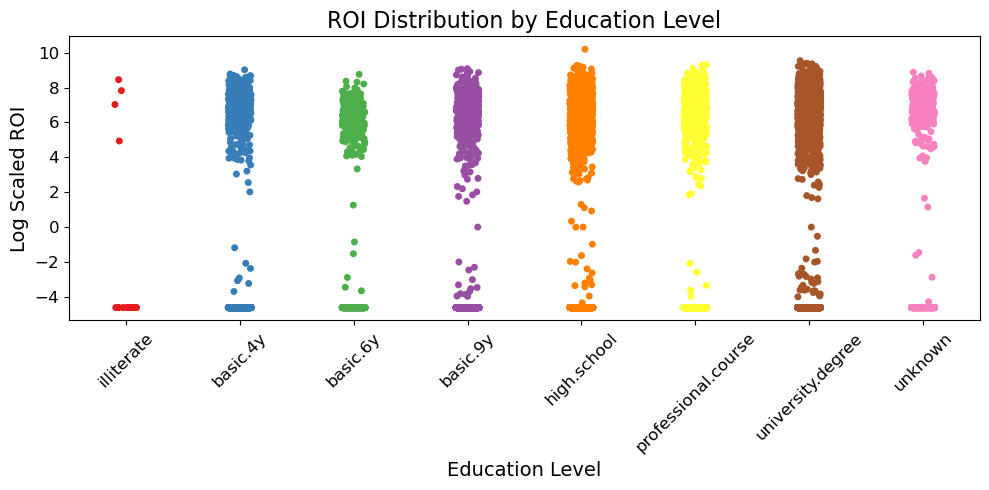

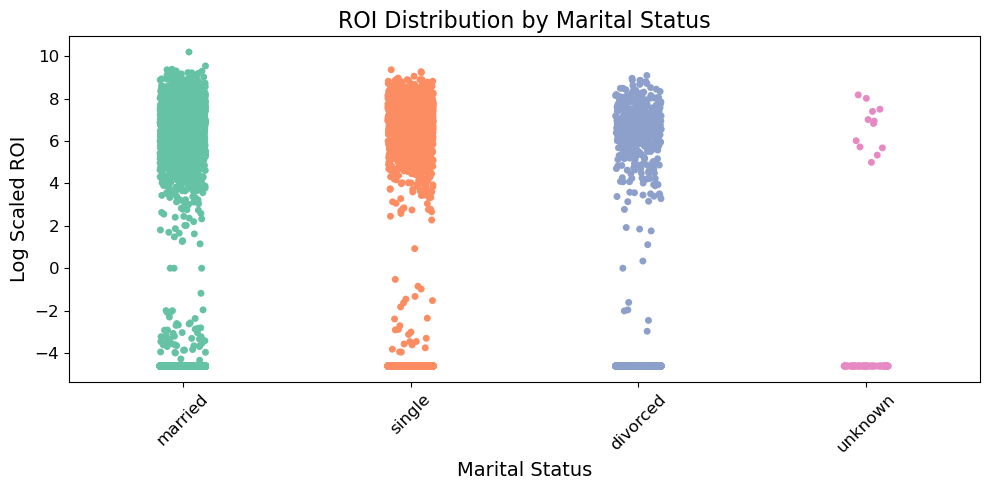

In [9]:
# Order by education level
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']
df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)

# Scaled ROI against Education
plt.figure(figsize=(10, 5))
sns.stripplot(x='education', y='log_scaled_roi', data=df, hue='education', palette='Set1', legend=False)
plt.title('ROI Distribution by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Log Scaled ROI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Scaled ROI against Marital Status
plt.figure(figsize=(10, 5))
sns.stripplot(x='marital', y='log_scaled_roi', data=df, hue='marital', palette='Set2', legend=False)
plt.title('ROI Distribution by Marital Status', fontsize=16)
plt.xlabel('Marital Status', fontsize=14)
plt.ylabel('Log Scaled ROI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## Use OneHotEncoder to handle categorical variables

In [10]:
categorical_features = ['job', 'marital', 'education', 'month', 'day_of_week', 'pdays_bins', 'previous_bins']
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

# Drop original columns and merge encoded ones
df = df.drop(columns=categorical_features)
df = pd.concat([df, categorical_df], axis=1)

# Remove unnecessary columns
df = df.drop(['log_scaled_roi','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'],axis = 1)

# Fill missing values
imputer = SimpleImputer(strategy='most_frequent')  # Or use "mean" or "most_frequent"
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Display the dataframe
print(df[['age', 'campaign', 'duration', 'contact', 'subscribed', 'roi']])

        age  campaign  duration  contact  subscribed          roi
0      56.0       1.0     261.0      0.0         0.0  -100.000000
1      57.0       1.0     149.0      0.0         0.0  -100.000000
2      37.0       1.0     226.0      0.0         0.0  -100.000000
3      40.0       1.0     151.0      0.0         0.0  -100.000000
4      56.0       1.0     307.0      0.0         0.0  -100.000000
...     ...       ...       ...      ...         ...          ...
41183  73.0       1.0     334.0      1.0         1.0  1696.407186
41184  46.0       1.0     383.0      1.0         0.0  -100.000000
41185  56.0       2.0     189.0      1.0         0.0  -100.000000
41186  44.0       1.0     442.0      1.0         1.0  1257.466063
41187  74.0       3.0     239.0      1.0         0.0  -100.000000

[41188 rows x 6 columns]


## Split and scale data

In [11]:
# Define features and target
X = df.drop(columns=['roi'])
y = df['roi']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train model using Random Forest

##### MAE: 2.30
##### MRSE: 49.98
##### R2 Score: 0.997

##### Most important features in the training set are "subscribed", "duration", "campaign" and "contact".

In [12]:
# Train model
model = RandomForestRegressor(random_state=100)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=df.drop(columns=['roi']).columns)
print("Feature Importances:")
print(feature_importances.sort_values(ascending=False))

MAE: 1.7067789436497776
RMSE: 39.79401412778073
R2 Score: 0.9960103456076749
Feature Importances:
subscribed                       4.365211e-01
duration                         3.864902e-01
campaign                         1.294829e-01
contact                          3.720179e-02
job_housemaid                    8.721741e-03
pdays_bins_Never Contacted       2.544184e-04
day_of_week_tue                  2.045292e-04
poutcome_encoded                 1.968533e-04
previous_bins_Never              1.902973e-04
age                              1.705782e-04
day_of_week_thu                  1.084590e-04
housing                          5.836420e-05
education_university.degree      4.458008e-05
education_professional.course    4.438251e-05
month_oct                        3.188177e-05
job_technician                   2.227927e-05
pdays_bins_6+                    2.161759e-05
loan                             2.060150e-05
day_of_week_wed                  1.975172e-05
marital_single              

## Plot predicted v.s. actual values

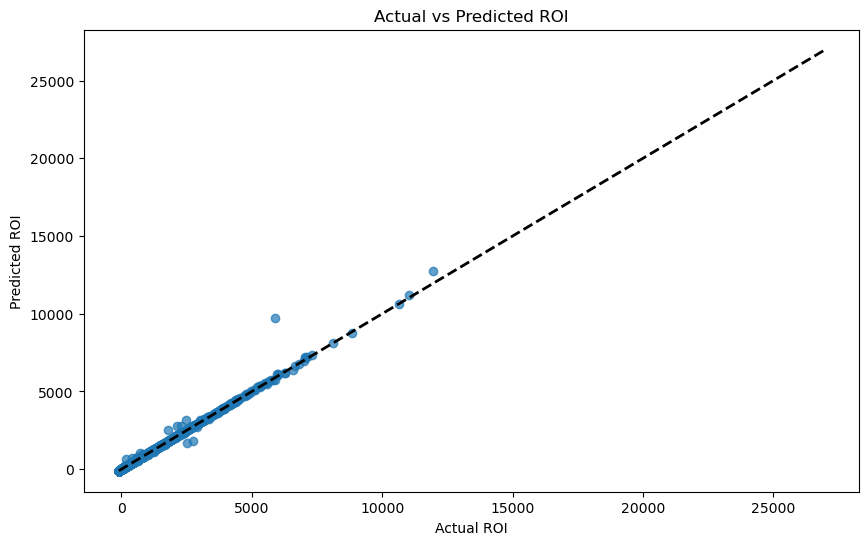

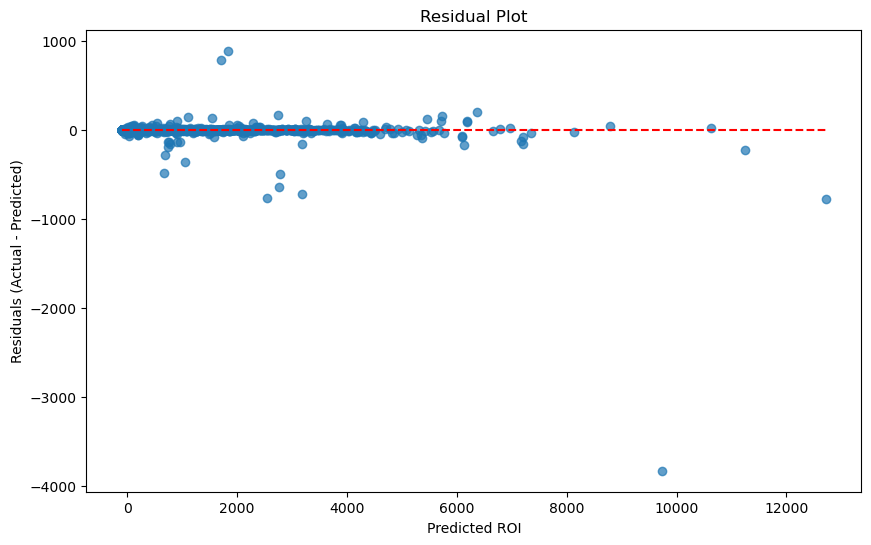

In [13]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ideal line
plt.xlabel('Actual ROI')
plt.ylabel('Predicted ROI')
plt.title('Actual vs Predicted ROI')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted ROI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

## Plot learning curve

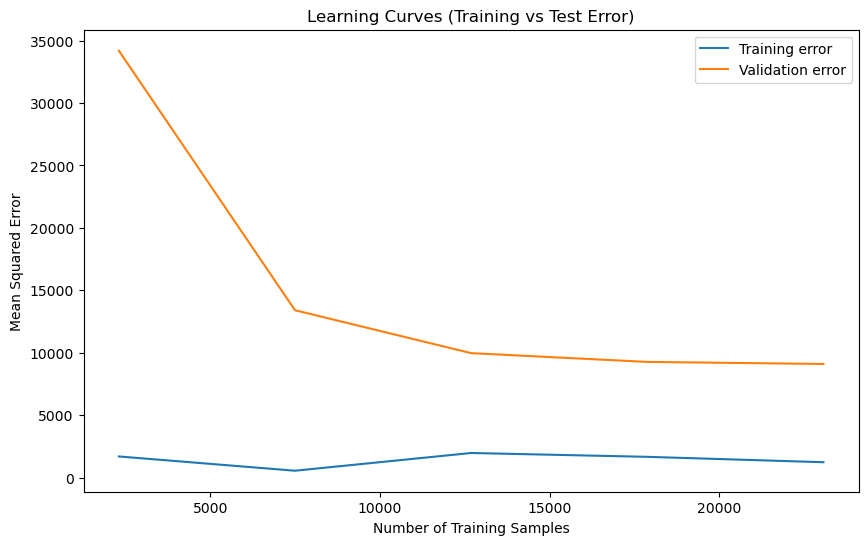

In [14]:
# Compute learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(-train_scores, axis=1), label='Training error')
plt.plot(train_sizes, np.mean(-test_scores, axis=1), label='Validation error')
plt.title('Learning Curves (Training vs Test Error)')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()